## Introduction

In this notebook, I use natural language processing and sentiment analysis to predict whether yelp reviews are positive or negative. The basic steps of this project are as follows:

1. Load in the data
2. Do some basic EDA
3. Clean, process, and vectorize the text
4. Produce Logistic Regression, Naive Bayes, KNN, Decision Tree, and Random Forest models
5. Compare the models' performances

The data was originally provided by Yelp to promote a public dataset challenge, and I found it on kaggle [here](https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset)

Note that the dataset contains ~7 million reviews, but the below results are for the first 100k

## Libraries

In [1]:
# General, Text, and Word Parsing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import warnings
from nltk.corpus import stopwords
from langdetect import detect
import string
import re
from wordcloud import WordCloud

# Model Libraries
import sys
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

## Load in Data

In [2]:
lines = []
with open('yelp_academic_dataset_review.json') as file:
    for i, l in enumerate(file):
        lines.append(json.loads(l))
        if i + 1 >= 100000:
            break
data = pd.DataFrame(lines)

## Exploratory Data Analysis

#### Print out the data's first few values and other summary stats

In [3]:
print(f"{data.head()}\n\n")
print(data.info())

                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0    3.0       0      0     0   
1    5.0       1      0     1   
2    3.0       0      0     0   
3    5.0       1      0     1   
4    4.0       1      0     1   

                                                text                 date  
0  If you decide to eat here, just be aware it is...  2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year...  2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm...  2014-02-05 20:30:30  
3  Wow!  Yummy, different,  delici

#### Plot stars by number of reviews

Text(0, 0.5, 'review count')

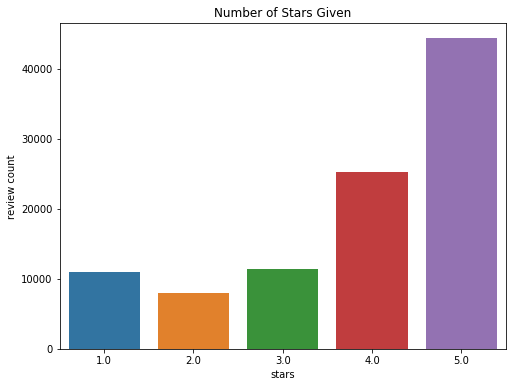

In [4]:
reviews = data.drop(['business_id', 'review_id', 'user_id'], axis = 1)
fig,ax= plt.subplots(figsize=(8,6))
cplot = sns.countplot(x = "stars", data = data)
cplot.set_title("Number of Stars Given")
cplot.set_ylabel("review count")

Looks like our data is left-skewed; most common value of stars is 5

#### Plot number of reviews by year

Text(0.5, 1.0, 'Reviews by Year')

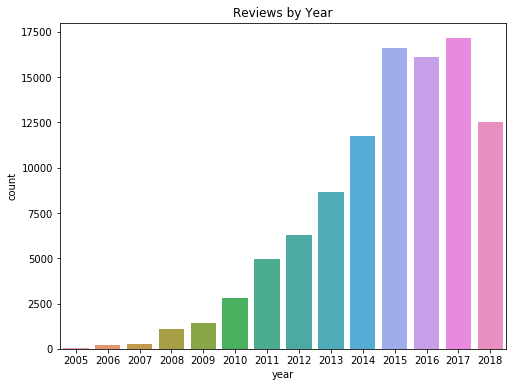

In [5]:
reviews['year'] = reviews['date'].str[:4]

fig,ax= plt.subplots(figsize=(8,6))
sns.countplot(x = reviews['year'] )

plt.title("Reviews by Year")

#### Calc the average review length annd plot its distribution

Mean text length: 548.43833 characters
Median text length: 395.0 characters



Text(0.5, 1.0, 'Text Length Distribution')

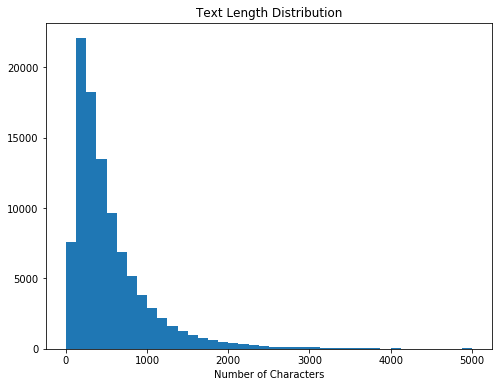

In [6]:
data['text length'] = data['text'].apply(len)

# calc mean and median of review length
print(f"Mean text length: {data['text length'].mean()} characters")
print(f"Median text length: {data['text length'].median()} characters\n")

# plot review length distribution
fig = plt.figure(figsize=(8, 6))
plt.hist(data['text length'], density = False, bins=40)  
plt.xlabel('Number of Characters')
plt.title("Text Length Distribution")

#### Word Cloud of 5-star reviews

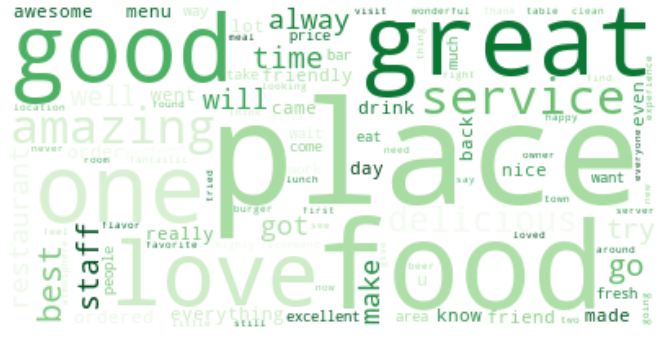

In [7]:
# extract text of five-star reviews
five_star_reviews = data[reviews.stars == 5]
five_star_reviews = five_star_reviews['text']
text = " ".join(i for i in five_star_reviews)

# produce wordcloud
cloud = WordCloud(background_color="white", max_words=100, contour_width = 3, colormap = 'Greens')
cloud.generate(text)

# plot results
plt.figure(figsize=(12,6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Cloud of 1-star reviews

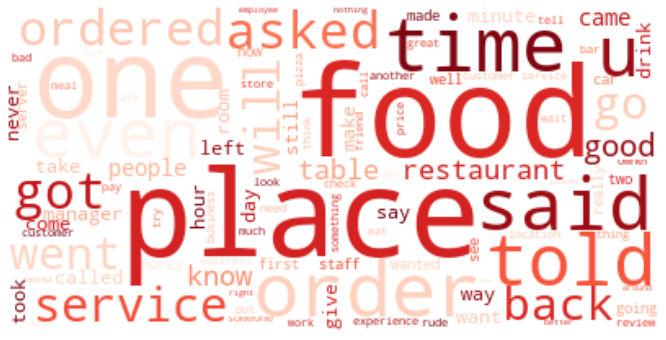

In [8]:
# extract text of one-star reviews
one_star_reviews = reviews[reviews.stars == 1]
one_star_reviews = one_star_reviews['text']
text = " ".join(i for i in one_star_reviews)

# produce wordcloud
cloud = WordCloud(background_color="white", max_words=100, contour_width = 3, colormap = 'Reds')
cloud.generate(text)

# plot results
plt.figure(figsize=(12,6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Data Cleaning

#### Look at a quick summary of our data

In [9]:
data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text length
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,513
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,829
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,339
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,243
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,534


#### Check for empty values/text and remove where necessary

In [10]:
data.isnull().any().any()

data['text'] = data['text'].dropna()
print(data['text']) # looks like 1 review was blank

0        If you decide to eat here, just be aware it is...
1        I've taken a lot of spin classes over the year...
2        Family diner. Had the buffet. Eclectic assortm...
3        Wow!  Yummy, different,  delicious.   Our favo...
4        Cute interior and owner (?) gave us tour of up...
                               ...                        
99995    Came here for lunch with a group. They were bu...
99996    The equipment is so old and so felty! I just u...
99997    This is one of my favorite Mexican restaurants...
99998    Came here for brunch - had an omlette ($19 + t...
99999    Came in for my 5-6 month prophy and saw Kara -...
Name: text, Length: 100000, dtype: object


No null values in our data

#### Remove any non-English reviews

In [11]:
def return_lang(s):
    return detect(s)

        
data['language'] = data.text.apply(return_lang)
print(data['language'].value_counts())

cleaned_data = data[data.language == "en"]
print(cleaned_data)

en       99895
es          28
de          18
fr          15
pt           6
it           6
nl           4
zh-cn        4
sv           4
da           3
af           3
so           3
cy           2
ja           2
no           1
hu           1
id           1
tl           1
vi           1
cs           1
sl           1
Name: language, dtype: int64
                    review_id                 user_id             business_id  \
0      KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1      BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2      saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3      AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4      Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   
...                       ...                     ...                     ...   
99995  pAEbIxvr6ebx2bHc1XvguA  SMH5CeiLvKx61lKwtLZ_PA  lV0k3BnslFRkuWD_kbKd0Q   
99996  x

#### Extract stars and text since those are the only columns we need for this analysis

In [12]:
cleaned_data = cleaned_data[["stars", "text"]]
cleaned_data.head()

,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...


#### Add a column called "sentiment" that is "positive" if a review has 4 or 5 stars and "negative" if it has 1 or 2. I'm ignoring 3-star reviews since they likely have both positive and negative sentiment
(Note that removing 3-star reviews reduces our data to ~88.5k reviews)

In [13]:
# removes reviews with 3 stars
cleaned_data = cleaned_data[cleaned_data.stars != 3]

# creates new column "sentiment" that gives us our sentiment
cleaned_data['sentiment'] = np.where(cleaned_data['stars'] == 5 , "positive", np.where(cleaned_data['stars'] == 4 , "positive", "negative"))
print(cleaned_data)

       stars                                               text sentiment
1        5.0  I've taken a lot of spin classes over the year...  positive
3        5.0  Wow!  Yummy, different,  delicious.   Our favo...  positive
4        4.0  Cute interior and owner (?) gave us tour of up...  positive
5        1.0  I am a long term frequent customer of this est...  negative
6        5.0  Loved this tour! I grabbed a groupon and the p...  positive
...      ...                                                ...       ...
99995    4.0  Came here for lunch with a group. They were bu...  positive
99996    1.0  The equipment is so old and so felty! I just u...  negative
99997    4.0  This is one of my favorite Mexican restaurants...  positive
99998    2.0  Came here for brunch - had an omlette ($19 + t...  negative
99999    5.0  Came in for my 5-6 month prophy and saw Kara -...  positive

[88541 rows x 3 columns]


#### Convert letters to lowercase and remove punctuation

In [14]:
# converts reviews to lowercase
cleaned_data['text'] = cleaned_data['text'].str.lower()

# removes punctuation via "re"
cleaned_data['text'] = cleaned_data['text'].str.replace(r'[^\w\s]+', '')

#### Remove stopwords

In [15]:
stop = stopwords.words("english")

# I noticed a few of the stop words have punctuation that should be removed 
stop = [''.join(c for c in s if c not in string.punctuation) for s in stop]

# Removes stop words for all reviews
cleaned_data['text'] = cleaned_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Models

#### Define x as the text of the reviews and y as the sentiment

In [16]:
x = cleaned_data['text']
y = cleaned_data['sentiment']
print(x)

1        ive taken lot spin classes years nothing compa...
3        wow yummy different delicious favorite lamb cu...
4        cute interior owner gave us tour upcoming pati...
5        long term frequent customer establishment went...
6        loved tour grabbed groupon price great perfect...
                               ...                        
99995    came lunch group busy still room us service go...
99996    equipment old felty upgraded multi club member...
99997    one favorite mexican restaurants authentic men...
99998    came brunch omlette 19 tax tip 26 food wayyyyy...
99999    came 56 month prophy saw kara new hygenist ter...
Name: text, Length: 88541, dtype: object


#### Use CountVectorizer() to tokenize the text

In [17]:
cv = CountVectorizer().fit(x)
x = cv.transform(x)

#### Create training and test sets using 80/20 split

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 55)

#### Print out the shapes of the sets to make sure everythink looks right

In [19]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (70832, 92824)
y_train shape: (70832,)
x_test shape: (17709, 92824)
y_test shape: (17709,)


## Logistic Regression

First, I will iterate through different values of C to find the optimal value

In [20]:
warnings.filterwarnings("ignore")
c_values = [0.001, 0.010, 0.1, 1, 10, 100, 1000]
lr_train_accs_list = []
lr_test_accs_list = []

# takes quite a bit of time to iterate through this
for i in c_values:
    lr = LogisticRegression(C = i, solver = 'sag').fit(x_train, y_train)
    lr_train_pred = lr.predict(x_train)
    lr_test_pred = lr.predict(x_test)
    lr_train_accs_list.append(round(accuracy_score(y_train,lr_train_pred), 3))
    lr_test_accs_list.append(round(accuracy_score(y_test,lr_test_pred), 3))
print(c_values)
print(lr_train_accs_list)
print(lr_test_accs_list)

[0.001, 0.01, 0.1, 1, 10, 100, 1000]
[0.89, 0.943, 0.968, 0.977, 0.978, 0.978, 0.978]
[0.89, 0.936, 0.949, 0.949, 0.95, 0.95, 0.95]


It looks like 100 performs the best, so I will use that value

In [21]:
warnings.filterwarnings("ignore")

# Fit model
lr = LogisticRegression(C = 100, solver='sag').fit(x_train,y_train)

# Make predictions
lr_train_pred = lr.predict(x_train)
lr_test_pred = lr.predict(x_test)

# Calc accuracies
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test,lr_test_pred)

# Output the accuracies
print(f"Accuracy on training set: {lr_train_acc}")
print(f"Accuracy on test set: {lr_test_acc}\n\n")

# Output the confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test,lr_test_pred)}\n\n")

# Output the classification report
print(f"Classification Report: \n{classification_report(y_test,lr_test_pred)}")

Accuracy on training set: 0.9780466455839169
Accuracy on test set: 0.9496301315715173


Confusion Matrix: 
[[ 3219   515]
 [  377 13598]]


Classification Report: 
              precision    recall  f1-score   support

    negative       0.90      0.86      0.88      3734
    positive       0.96      0.97      0.97     13975

    accuracy                           0.95     17709
   macro avg       0.93      0.92      0.92     17709
weighted avg       0.95      0.95      0.95     17709



## Naive Bayes

#### Using multinomial as it is best suited for text classification

In [22]:
# Fit model
nb = MultinomialNB()
nb.fit(x_train, y_train)

# Make predictions
nb_train_pred = nb.predict(x_train)
nb_test_pred = nb.predict(x_test)

# Calc accuracies
nb_train_acc = accuracy_score(y_train, nb_train_pred)
nb_test_acc = accuracy_score(y_test, nb_test_pred)

# Output accuracies
print(f"Accuracy on training set: {nb_train_acc}")
print(f"Accuracy on test set: {nb_test_acc}\n\n")

# Output the confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test, nb_test_pred)}\n\n")

# Output the classification report
print(f"Classification Report: \n{classification_report(y_test, nb_test_pred)}")

Accuracy on training set: 0.9380223627738875
Accuracy on test set: 0.9200971257552657


Confusion Matrix: 
[[ 3034   700]
 [  715 13260]]


Classification Report: 
              precision    recall  f1-score   support

    negative       0.81      0.81      0.81      3734
    positive       0.95      0.95      0.95     13975

    accuracy                           0.92     17709
   macro avg       0.88      0.88      0.88     17709
weighted avg       0.92      0.92      0.92     17709



## K-Nearest Neighbor

#### First, I will plot an elbow graph to find the optimal # of neighbors

In [23]:
errors = []
k_values = list(range(1, 11))
# takes some time to iterate through this
for i in k_values:
    knn_mod = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
    pred_i = knn_mod.predict(x_test)
    errors.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

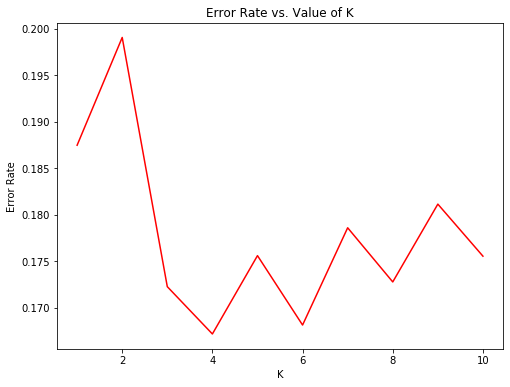

In [24]:
plt.figure(figsize=(8,6))
plt.plot(k_values,errors,color= "red")
plt.title("Error Rate vs. Value of K")
plt.xlabel("K")
plt.ylabel("Error Rate")


Looks like k=4 does a good job, so I will choose that value

In [25]:
# Fit model
neigh = KNeighborsClassifier(n_neighbors = 4).fit(x_train,y_train)

# Make predictions
knn_train_pred = neigh.predict(x_train)
knn_test_pred = neigh.predict(x_test)

# Calc accuracies
knn_train_acc = accuracy_score(y_train,knn_train_pred)
knn_test_acc = accuracy_score(y_test,knn_test_pred)

# Output accuracies
print(f"Accuracy on training set: {knn_train_acc}")
print(f"Accuracy on test set: {knn_test_acc}\n\n")

# Output the confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test,knn_test_pred)}\n\n")

# Output the classification report
print(f"Classification Report: \n{classification_report(y_test,knn_test_pred)}")

Accuracy on training set: 0.8934662299525639
Accuracy on test set: 0.8327968829408775


Confusion Matrix: 
[[ 1225  2509]
 [  452 13523]]


Classification Report: 
              precision    recall  f1-score   support

    negative       0.73      0.33      0.45      3734
    positive       0.84      0.97      0.90     13975

    accuracy                           0.83     17709
   macro avg       0.79      0.65      0.68     17709
weighted avg       0.82      0.83      0.81     17709



## Decision Tree

In [26]:
# Fit model
dt  = DecisionTreeClassifier(criterion = "entropy")
dt.fit(x_train,y_train)

# Make predictions
dt_train_pred = dt.predict(x_train)
dt_test_pred = dt.predict(x_test)

# Calc accuracies
dt_train_acc = accuracy_score(y_train,dt_train_pred)
dt_test_acc = accuracy_score(y_test,dt_test_pred)

# Output the accuracies
print(f"Accuracy on training set: {dt_train_acc}")
print(f"Accuracy on test set: {dt_test_acc}\n\n")

# Output the confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test,dt_test_pred)}\n\n")

# Output the classification report
print(f"Classification Report: \n{classification_report(y_test,dt_test_pred)}")

Accuracy on training set: 1.0
Accuracy on test set: 0.8639110057033147


Confusion Matrix: 
[[ 2504  1230]
 [ 1180 12795]]


Classification Report: 
              precision    recall  f1-score   support

    negative       0.68      0.67      0.68      3734
    positive       0.91      0.92      0.91     13975

    accuracy                           0.86     17709
   macro avg       0.80      0.79      0.79     17709
weighted avg       0.86      0.86      0.86     17709



## Random Forest

#### First I want to find the optimal number of n_estimators

In [27]:
dt_train=[]
dt_test=[]
depth=[]
# takes quite a bit of time to iterate through this
for i in range(1,20):
    my_random_forest = RandomForestClassifier(n_estimators=i,random_state=1)
    my_random_forest.fit(x_train, y_train)
    dt_train.append(my_random_forest.score(x_train, y_train))
    dt_test.append(my_random_forest.score(x_test, y_test))
    depth.append(i)

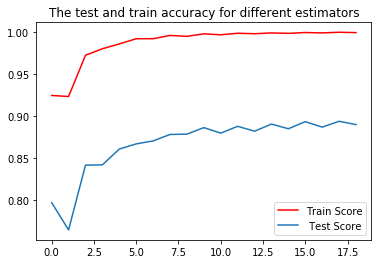

Optimal estimators: 18


In [28]:
plt.figure()
plt.title('The test and train accuracy for different estimators')
plt.plot(dt_train,color='red',label='Train Score')
plt.plot(dt_test,label=' Test Score')
plt.legend()
plt.show()
optimal_estimators = depth[np.argmax(dt_test)]
print(f"Optimal estimators: {depth[np.argmax(dt_train)]}")


#### Although I plotted this model on both the training and test data, the "optimal_estimators" value is based on the training data results only so I can avoid goal-seeking. Ultimately, as can be seen above, the optimal # is found to be 18

In [29]:
# Fit model
rf = RandomForestClassifier(n_estimators = optimal_estimators, criterion = "entropy").fit(x_train,y_train)

# Make predictions
rf_train_pred = rf.predict(x_train)
rf_test_pred = rf.predict(x_test)

# Calc accuracies
rf_train_acc = accuracy_score(y_train,rf_train_pred)
rf_test_acc = accuracy_score(y_test,rf_test_pred)

# Output accuracies
print(f"Accuracy on training set: {rf_train_acc}")
print(f"Accuracy on test set: {rf_test_acc}\n\n")

# Output the confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test,rf_test_pred)}\n\n")

# Output the classification report
print(f"Classification Report: \n{classification_report(y_test,rf_test_pred)}")

Accuracy on training set: 0.9992799864468037
Accuracy on test set: 0.8981308938957592


Confusion Matrix: 
[[ 2150  1584]
 [  220 13755]]


Classification Report: 
              precision    recall  f1-score   support

    negative       0.91      0.58      0.70      3734
    positive       0.90      0.98      0.94     13975

    accuracy                           0.90     17709
   macro avg       0.90      0.78      0.82     17709
weighted avg       0.90      0.90      0.89     17709



## Plotting Accuracies by Model

#### Plot accuracies from highest to lowest

Text(0.5, 1.0, 'Accuracy by Model')

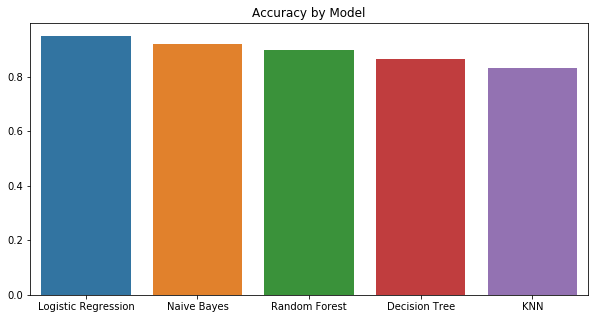

In [30]:
# sort the accuracies from highest to lowest and prep it to be plotted
models_and_accs = {"Logistic Regression": lr_test_acc, "Naive Bayes": nb_test_acc, "KNN": knn_test_acc, "Decision Tree": dt_test_acc, "Random Forest": rf_test_acc}
models_and_accs_tups = sorted(models_and_accs.items(), key=lambda x:x[1], reverse = True)
models, accs = [list(tup) for tup in zip(*models_and_accs_tups)]

# plot the sorted accuracies 
plt.figure(figsize = (10,5))
acc_plot = sns.barplot(models, accs)
acc_plot.set_title('Accuracy by Model')